In [11]:
!pip3 install sklearn tensorflow matplotlib numpy pandas yahoo_fin


In [12]:
import os
import time
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import numpy as np
import pandas as pd
import random

# Window size or the sequence length
N_STEPS = 30
# Lookup step, 1 is the next day
LOOKUP_STEP = 30

# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")

### model parameters
date="19/02/2021"
N_LAYERS = 3
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False

### training parameters

# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "Adam"
BATCH_SIZE = 16
EPOCHS = 400
SHUFFLE = False
# Apple stock market
ticker = "BTC-USD"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

# Sección nueva

Set# Sección nueva

In [13]:


# set seed, so we can get the same results after rerunning several times
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)


def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, 
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    """
    Loads data from Yahoo Finance source, as well as scaling, shuffling, normalizing and splitting.
    Params:
        ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
        n_steps (int): the historical sequence length (i.e window size) used to predict, default is 50
        scale (bool): whether to scale prices from 0 to 1, default is True
        shuffle (bool): whether to shuffle the data, default is True
        lookup_step (int): the future lookup step to predict, default is 1 (e.g next day)
        test_size (float): ratio for test data, default is 0.2 (20% testing data)
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
        #df = si.get_data(ticker)

    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")

    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()

    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."

    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler

        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler

    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    df['future']= df['future'].fillna(df['adjclose'][-1])
    #print(df['adjclose'][-1])
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    
    # drop NaNs
    df.dropna(inplace=True)

    sequence_data = []
    sequences = deque(maxlen=n_steps)

    for entry, target in zip(df[feature_columns].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])

    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 59 (that is 50+10-1) length
    # this last_sequence will be used to predict in future dates that are not available in the dataset
    last_sequence = list(sequences) + list(last_sequence)
    # shift the last sequence by -1
    last_sequence = np.array(pd.DataFrame(last_sequence).shift(-1).dropna())
    # add to result
    result['last_sequence'] = last_sequence
    
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    print(len(y))
    
    s = len(y) - lookup_step
    X = np.array(X)
    print(np.array(X).shape)
    y = np.array(y)
    print(s)
    # reshape X to fit the neural network
    X = X.reshape((X.shape[0], X.shape[2], X.shape[1]))
    result["x"] = X
    X = X[:s]
    y = y[:s]
    # split the dataset
    result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)
    # return the result
    return result


def create_model(sequence_length, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), input_shape=(None, sequence_length)))
            else:
                model.add(cell(units, return_sequences=True, input_shape=(None, sequence_length)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [14]:
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)


2315
(2315, 30, 5)
2285


In [15]:
data["y_train"].shape

(1828,)

In [16]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import os
import pandas as pd


# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")

if not os.path.isdir("logs"):
    os.mkdir("logs")

if not os.path.isdir("data"):
    os.mkdir("data")

# load the data
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)

# save the dataframe
data["df"].to_csv(ticker_data_filename)

# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

model.save(os.path.join("results", model_name) + ".h5")

2315
(2315, 30, 5)
2285
Epoch 1/400
115/115 [==============================] - 6s 18ms/step - loss: 0.0037 - mean_absolute_error: 0.0523 - val_loss: 0.0027 - val_mean_absolute_error: 0.0289

Epoch 00001: val_loss improved from inf to 0.00268, saving model to results/2021-02-19_BTC-USD-huber_loss-Adam-LSTM-seq-30-step-30-layers-3-units-256.h5
Epoch 2/400
115/115 [==============================] - 1s 8ms/step - loss: 0.0017 - mean_absolute_error: 0.0336 - val_loss: 0.0023 - val_mean_absolute_error: 0.0272

Epoch 00002: val_loss improved from 0.00268 to 0.00229, saving model to results/2021-02-19_BTC-USD-huber_loss-Adam-LSTM-seq-30-step-30-layers-3-units-256.h5
Epoch 3/400
115/115 [==============================] - 1s 8ms/step - loss: 0.0023 - mean_absolute_error: 0.0365 - val_loss: 0.0023 - val_mean_absolute_error: 0.0272

Epoch 00003: val_loss improved from 0.00229 to 0.00227, saving model to results/2021-02-19_BTC-USD-huber_loss-Adam-LSTM-seq-30-step-30-layers-3-units-256.h5
Epoch 4/40

2315
(2315, 30, 5)
2285
Mean Absolute Error: 1116.0852329348322
Future price after 30 days is 50554.82$


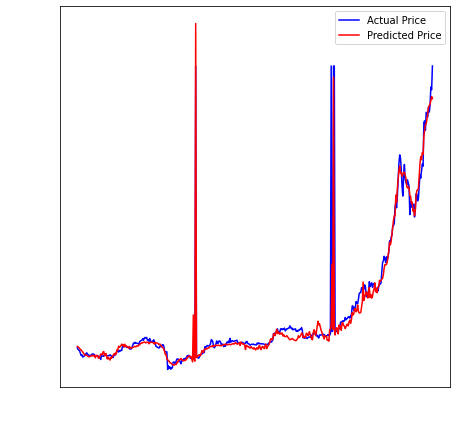

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def plot_graph(model, data):
    fig = plt.figure(figsize=(7,7))
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    plt.plot(y_test, c='b', )
    plt.plot(y_pred, c='r')
    plt.xlabel("Days").set_color('white')
    plt.ylabel("Price").set_color('white')
    plt.legend(["Actual Price", "Predicted Price"])
    plt.tick_params(axis='x', colors='white')
    plt.tick_params(axis='y', colors='white')
    plt.show()

def get_accuracy(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    y_pred = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_pred[LOOKUP_STEP:]))
    y_test = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_test[LOOKUP_STEP:]))
    return accuracy_score(y_test, y_pred)


def predict(model, data, classification=False):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][:N_STEPS]
    # retrieve the column scalers
    column_scaler = data["column_scaler"]
    # reshape the last sequence
    last_sequence = last_sequence.reshape((last_sequence.shape[1], last_sequence.shape[0]))
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    predicted_price = column_scaler["adjclose"].inverse_transform(prediction)[0][0]
    return predicted_price


# load the data
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE,
                feature_columns=FEATURE_COLUMNS, shuffle=SHUFFLE)

# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

# evaluate the model
mse, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
mae = np.array([mae])
# calculate the mean absolute error (inverse scaling)
mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform(mae.reshape(1, -1))[0][0]
print("Mean Absolute Error:", mean_absolute_error)
# predict the future price
future_price = predict(model, data)
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
#print("Accuracy Score:", get_accuracy(model, data), ticker)
plot_graph(model, data)

# Resultados 

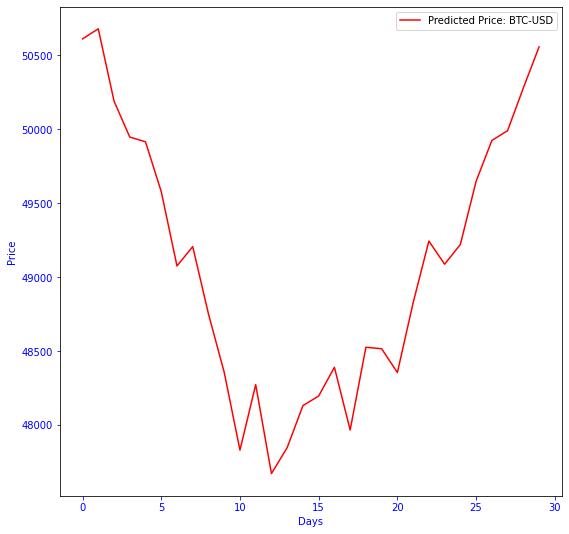

In [18]:
    X_test = data["x"]
    y_pred = model.predict(X_test)
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    fig = plt.figure(figsize=(9,9))
    plt.plot(y_pred[-LOOKUP_STEP:], c='r')
    plt.xlabel("Days").set_color('blue')
    plt.ylabel("Price").set_color('blue')
    plt.legend(["Predicted Price: " + ticker])
    plt.tick_params(axis='x', colors='blue')
    plt.tick_params(axis='y', colors='blue')
    plt.savefig(ticker+"_"+date_now+'.png')
    plt.show()

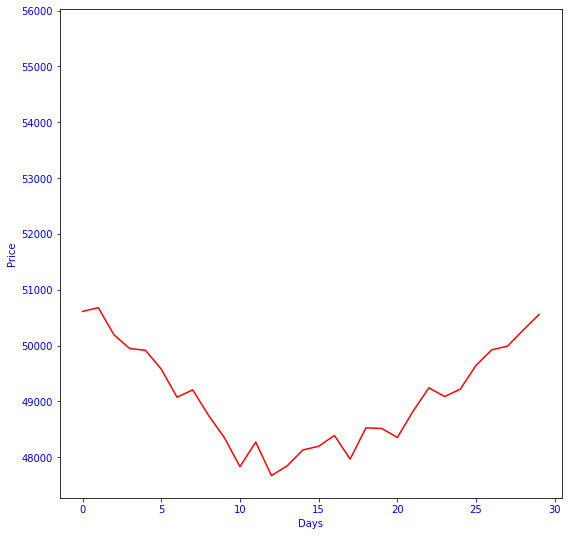

In [19]:
    df = si.get_data(ticker, start_date=date)
    df = df.reset_index()
    X_test = df["adjclose"]
    fig = plt.figure(figsize=(9,9))
    plt.plot(X_test, c='b')
    plt.plot(y_pred[-LOOKUP_STEP:], c='r')
    plt.xlabel("Days").set_color('blue')
    plt.ylabel("Price").set_color('blue')
    plt.tick_params(axis='x', colors='blue')
    plt.tick_params(axis='y', colors='blue')
    plt.show()

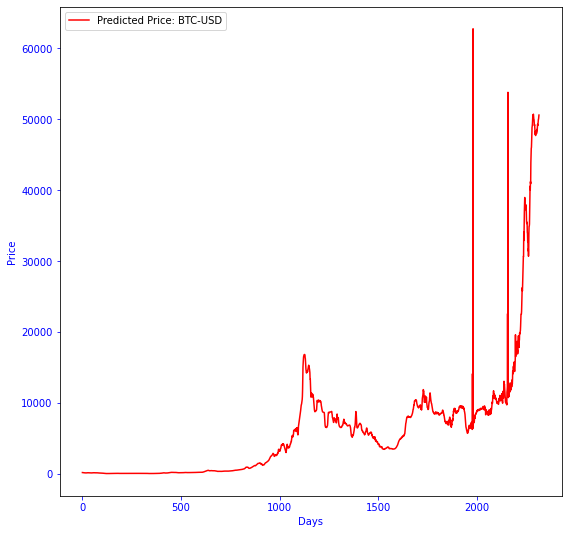

In [20]:
    X_test = data["x"]
    y_pred = model.predict(X_test)
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    fig = plt.figure(figsize=(9,9))
    plt.plot(y_pred, c='r')
    plt.xlabel("Days").set_color('blue')
    plt.ylabel("Price").set_color('blue')
    plt.legend(["Predicted Price: " + ticker])
    plt.tick_params(axis='x', colors='blue')
    plt.tick_params(axis='y', colors='blue')
    plt.savefig(ticker+"_"+date_now+'.png')
    plt.show()